# Feature engineering

En este notebook se incorporan algunas features extras derivadas de la ubicación de los locales en el espacio

In [1]:
!pip install cenpy
!pip install python-Levenshtein
!pip install osmnx
!pip install hdbscan
!pip install geopandas
!pip install contextily
!pip install pysal 

  Using cached numpy-1.21.4-cp39-cp39-macosx_10_9_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.4 which is incompatible.
  Using cached numpy-1.20.3-cp39-cp39-macosx_10_9_x86_64.whl (16.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import contextily
import cenpy
import numpy
import osmnx
import seaborn
import rasterio
from rasterio.plot import show as rioshow

%matplotlib inline

## Lectura de datos 

In [3]:
data = pd.read_csv('./data/geo_data.csv',  index_col=[0])

In [4]:
data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...                                       geometry  \
0    1500000  7500.000000  ...  POINT (-6515379.180859259 -4114970.853546773)   
1     125000  2500.000000  ...  POINT (-6515322.519238445 -4111251.604641595)   
2     590000  1425.120773  ...  POINT (-6515319.513612195 -4111882.057282486)   
3     730000  1763.000000  ...   POINT (-6515298.02895047 -4111865.284430326)   
4     550000  1929.000000  ...   POINT (-6515298.02895047 -4111865.284430326)   

     lon_planar    lat_planar                    calle  altura  comunas  \
0 -6.515379e+06 -4.114971e+06        Avenida Rivadavia   11674        9   
1 -6.515323e+06 -4.111252e+06     Avenida Lope de Vega    3500       11   
2 -6.515320e+06 -4.111882e+06  Avenida Francisco Beiró   -9999       10   
3 -6.515298e+06 -4.111865e+06  Avenida Francisco Beiró   -9999       10   
4 -6.515298e+06 -4.111865e+06  Avenida Francisco Beiró   -9999       10   

        barrios  densidad_poblacional  densidad_viviendas         distritos  
0       LINIERS           9162.535077         3428.444997  NO CARACTERIZADO  
1  VILLA DEVOTO           8847.779056         3215.839159  NO CARACTERIZADO  
2    VILLA REAL           8773.980909         3209.091367  NO CARACTERIZADO  
3    VILLA REAL           8773.980909         3209.091367  NO CARACTERIZADO  
4    VILLA REAL           8773.980909         3209.091367  NO CARACTERIZADO  

[5 rows x 26 columns]

In [5]:
data = data.drop("count_gastronomia", axis = 1)

In [6]:
data['geometry'] = data['geometry'].apply(wkt.loads)
geo_data = gpd.GeoDataFrame(data, crs='epsg:3857').to_crs(epsg=4326)

In [7]:
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...                     geometry    lon_planar  \
0    1500000  7500.000000  ...  POINT (-58.52865 -34.63930) -6.515379e+06   
1     125000  2500.000000  ...  POINT (-58.52814 -34.61181) -6.515323e+06   
2     590000  1425.120773  ...  POINT (-58.52811 -34.61647) -6.515320e+06   
3     730000  1763.000000  ...  POINT (-58.52792 -34.61634) -6.515298e+06   
4     550000  1929.000000  ...  POINT (-58.52792 -34.61634) -6.515298e+06   

     lat_planar                    calle  altura comunas       barrios  \
0 -4.114971e+06        Avenida Rivadavia   11674       9       LINIERS   
1 -4.111252e+06     Avenida Lope de Vega    3500      11  VILLA DEVOTO   
2 -4.111882e+06  Avenida Francisco Beiró   -9999      10    VILLA REAL   
3 -4.111865e+06  Avenida Francisco Beiró   -9999      10    VILLA REAL   
4 -4.111865e+06  Avenida Francisco Beiró   -9999      10    VILLA REAL   

   densidad_poblacional densidad_viviendas         distritos  
0           9162.535077        3428.444997  NO CARACTERIZADO  
1           8847.779056        3215.839159  NO CARACTERIZADO  
2           8773.980909        3209.091367  NO CARACTERIZADO  
3           8773.980909        3209.091367  NO CARACTERIZADO  
4           8773.980909        3209.091367  NO CARACTERIZADO  

[5 rows x 25 columns]

In [8]:
geo_data.shape

(3670, 25)

## Features no espaciales

### Avenidas

Crear un feature que define si el local se encuentra sobre una avenida o no

In [9]:
geo_data.loc[:, 'SobreAvenida'] = "0"
geo_data.loc[geo_data['calle'].str.contains("Avenida"), 'SobreAvenida'] = "1"

In [10]:
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...    lon_planar    lat_planar  \
0    1500000  7500.000000  ... -6.515379e+06 -4.114971e+06   
1     125000  2500.000000  ... -6.515323e+06 -4.111252e+06   
2     590000  1425.120773  ... -6.515320e+06 -4.111882e+06   
3     730000  1763.000000  ... -6.515298e+06 -4.111865e+06   
4     550000  1929.000000  ... -6.515298e+06 -4.111865e+06   

                     calle  altura  comunas       barrios  \
0        Avenida Rivadavia   11674        9       LINIERS   
1     Avenida Lope de Vega    3500       11  VILLA DEVOTO   
2  Avenida Francisco Beiró   -9999       10    VILLA REAL   
3  Avenida Francisco Beiró   -9999       10    VILLA REAL   
4  Avenida Francisco Beiró   -9999       10    VILLA REAL   

   densidad_poblacional  densidad_viviendas         distritos SobreAvenida  
0           9162.535077         3428.444997  NO CARACTERIZADO            1  
1           8847.779056         3215.839159  NO CARACTERIZADO            1  
2           8773.980909         3209.091367  NO CARACTERIZADO            1  
3           8773.980909         3209.091367  NO CARACTERIZADO            1  
4           8773.980909         3209.091367  NO CARACTERIZADO            1  

[5 rows x 26 columns]

Text(0.5, 1.0, 'Boxplot')

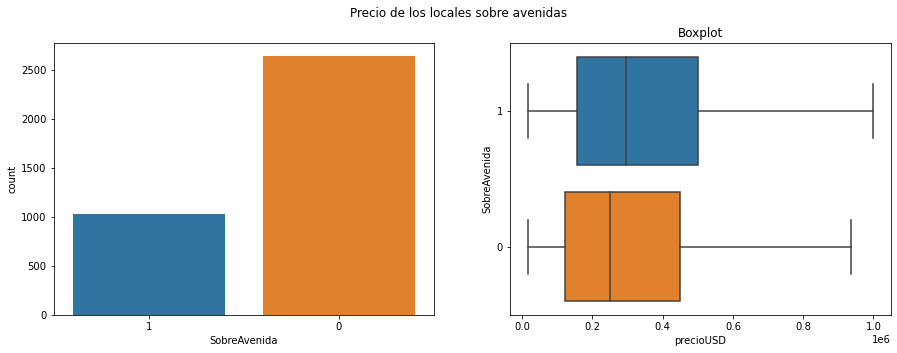

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precio de los locales sobre avenidas')

# Histograma
sns.countplot(ax=axes[0], x = geo_data['SobreAvenida'])

# Boxplot
sns.boxplot(ax=axes[1], x = geo_data['precioUSD'],  y = geo_data['SobreAvenida'], showfliers=False)
axes[1].set_title("Boxplot")

### Antiguedad

In [12]:
# Agregar variable binaria que define si los locales son a estrenar o no
geo_data['antig'].nunique()
estrenar = []
for i in geo_data["antig"]:
  if i == 0:
    estrenar.append("1")
  else:
    estrenar.append("0")

#Se agrega variable Aestrenar al data frame
geo_data["Aestrenar"] = estrenar

Text(0.5, 1.0, 'Boxplot')

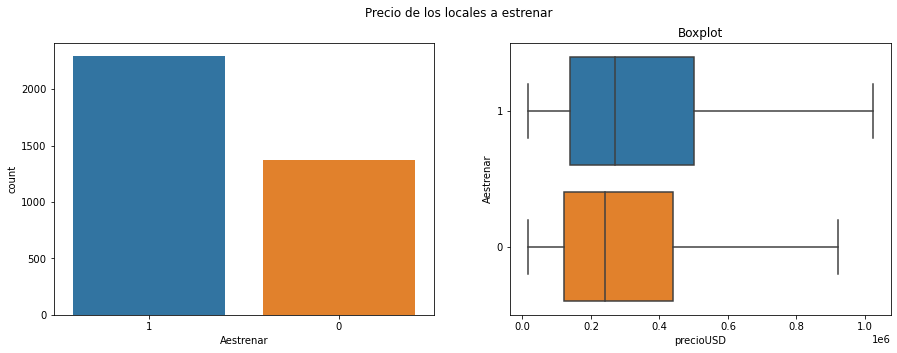

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precio de los locales a estrenar')

# Histograma
sns.countplot(ax=axes[0], x = geo_data['Aestrenar'])

# Boxplot
sns.boxplot(ax=axes[1], x = geo_data['precioUSD'],  y = geo_data['Aestrenar'], showfliers=False)
axes[1].set_title("Boxplot")

De la variable "antig" se generó una nueva variable "Aestrenar" donde los locales comerciales a esternar adquieren el valor 1 y el resto de locales el valor 0. Se observa una mayor cantidad de locales comerciales a estrenar (2318) que locales usados (1393).

### Cantidad de ambientes

#### Monoambiente

In [14]:
# Se agrega una variable binaria que considera si el local es un monoambiente o no.
ambis = []
for i in geo_data["ambientes"]:
    if i == 0:
        ambis.append("1")
    else:
        ambis.append("0")

#Se agrega variable monoambiente al data frame
geo_data["monoambiente"] = ambis

Text(0.5, 1.0, 'Boxplot')

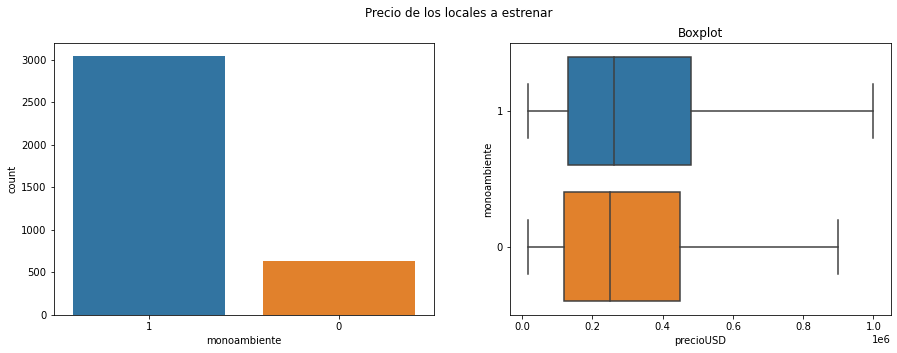

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precio de los locales a estrenar')

# Histograma
sns.countplot(ax=axes[0], x = geo_data['monoambiente'])

# Boxplot
sns.boxplot(ax=axes[1], x = geo_data['precioUSD'],  y = geo_data['monoambiente'], showfliers=False)
axes[1].set_title("Boxplot")

#### Clasificacion ambientes

In [16]:
geo_data.loc[geo_data.ambientes >= 5, 'clas_ambientes'] = 5
geo_data.loc[geo_data.ambientes < 5, 'clas_ambientes'] = geo_data.ambientes
geo_data['clas_ambientes'] = geo_data.clas_ambientes.astype(int).astype(str)
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...  altura  comunas       barrios  \
0    1500000  7500.000000  ...   11674        9       LINIERS   
1     125000  2500.000000  ...    3500       11  VILLA DEVOTO   
2     590000  1425.120773  ...   -9999       10    VILLA REAL   
3     730000  1763.000000  ...   -9999       10    VILLA REAL   
4     550000  1929.000000  ...   -9999       10    VILLA REAL   

   densidad_poblacional  densidad_viviendas         distritos  SobreAvenida  \
0           9162.535077         3428.444997  NO CARACTERIZADO             1   
1           8847.779056         3215.839159  NO CARACTERIZADO             1   
2           8773.980909         3209.091367  NO CARACTERIZADO             1   
3           8773.980909         3209.091367  NO CARACTERIZADO             1   
4           8773.980909         3209.091367  NO CARACTERIZADO             1   

   Aestrenar monoambiente clas_ambientes  
0          1            1              0  
1          0            1              0  
2          0            1              0  
3          0            1              0  
4          0            1              0  

[5 rows x 29 columns]

#### Clasificacion baños

In [17]:
geo_data.loc[geo_data.banios >= 4, 'clas_banios'] = 4
geo_data.loc[geo_data.banios < 4, 'clas_banios'] = geo_data.banios
geo_data['clas_banios'] = geo_data.clas_banios.astype(int).astype(str)
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...  comunas       barrios  densidad_poblacional  \
0    1500000  7500.000000  ...        9       LINIERS           9162.535077   
1     125000  2500.000000  ...       11  VILLA DEVOTO           8847.779056   
2     590000  1425.120773  ...       10    VILLA REAL           8773.980909   
3     730000  1763.000000  ...       10    VILLA REAL           8773.980909   
4     550000  1929.000000  ...       10    VILLA REAL           8773.980909   

   densidad_viviendas         distritos SobreAvenida  Aestrenar  monoambiente  \
0         3428.444997  NO CARACTERIZADO            1          1             1   
1         3215.839159  NO CARACTERIZADO            1          0             1   
2         3209.091367  NO CARACTERIZADO            1          0             1   
3         3209.091367  NO CARACTERIZADO            1          0             1   
4         3209.091367  NO CARACTERIZADO            1          0             1   

  clas_ambientes clas_banios  
0              0           0  
1              0           1  
2              0           2  
3              0           2  
4              0           1  

[5 rows x 30 columns]

## Features espaciales

### Map matching

In [18]:
geo_data_planar = geo_data.to_crs(epsg=3857)
# Se utiliza la proyeccion Mercator para tener una unidad de medida en metros
# Dado que el area es pequeña no hab'ria problemas por las distorciones que provoca una 
# pyoección de tipo cilindrica. La Mercator es una proyección conforme, es decir, respeta las 
# formas de los objetos no así su aréa o distancia. Si se trabajase con una área más 
# podría traer problemas en el cálculo de distancias. 

Se crea una objeto que posee los límites de la capa de locales. Es equivalente a la extensión de la capa pero considerando la distribución de los locales en la ciudad. No es solamente un bounding box.

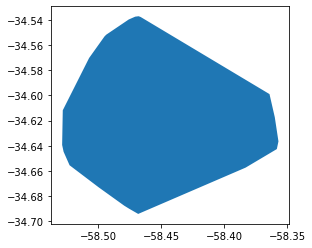

In [19]:
geo_data_ch = geo_data.unary_union.convex_hull
gpd.GeoSeries([geo_data_ch]).plot();

In [20]:
# Agregar buffer de 500 para las superpocisiones
geo_data_planar['buffer_500m'] = geo_data_planar.buffer(500)

#### Gastronomia

Se extraen la cantidad de locales gastronómicos que se encuentran en un buffer alrededor de cada local.

In [21]:
%%time
pois_gastronomia = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['restaurant', 'bar', 'biergarten', 'cafe', 'fast_food', 'food_court', 'ice_cream', 'pub']}
).reset_index()[["osmid", "amenity", "name", "cuisine", "name", "geometry"]]

CPU times: user 661 ms, sys: 43.3 ms, total: 704 ms
Wall time: 724 ms


In [22]:
pois_gastronomia.groupby('amenity').amenity.count()

amenity
bar            375
biergarten       5
cafe          1032
fast_food      731
food_court       1
ice_cream      346
pub            113
restaurant    2183
Name: amenity, dtype: int64

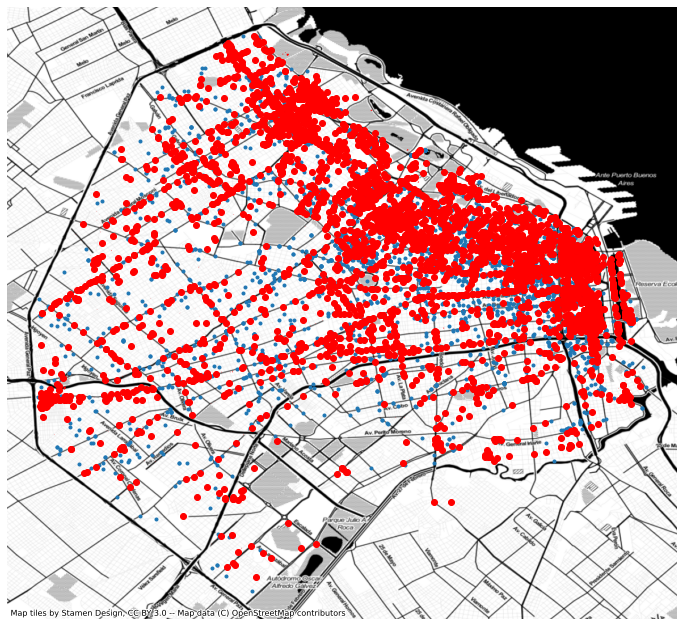

In [23]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_gastronomia.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [24]:
# Proyectar datos para realizar geoprocesos
pois_gastronomia_planar = pois_gastronomia.to_crs(epsg=3857)

In [25]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_gastronomia_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [26]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'count_gastronomia'
)
# Evaluar resultados
poi_count.head()

count_gastronomia
id                   
1                  52
2                   6
3                   4
4                   7
5                   7

In [27]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"count_gastronomia": 0})

In [28]:
geo_data.shape

(3670, 30)

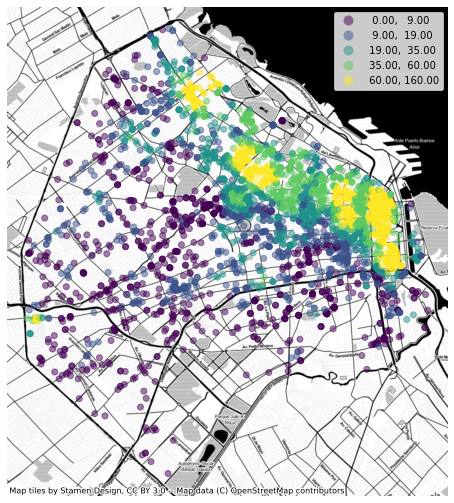

In [29]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="count_gastronomia",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

#### Educación

In [30]:
%%time
pois_education = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['college', 'kindergarten', 'library', 'language_school', 'school', 'university']}
).reset_index()[["osmid", "amenity", "name", "geometry"]]

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


CPU times: user 497 ms, sys: 31.5 ms, total: 529 ms
Wall time: 572 ms


In [31]:
pois_education.groupby('amenity').amenity.count()

amenity
college             369
kindergarten        781
language_school      11
library              85
school             1669
university           92
Name: amenity, dtype: int64

In [32]:
pois_education[:1]

osmid       amenity                                               name  \
0  331525623  kindergarten  Jardín de Infantes Nucleado D (EPCjc 08/18°) [...   

                      geometry  
0  POINT (-58.49620 -34.63594)

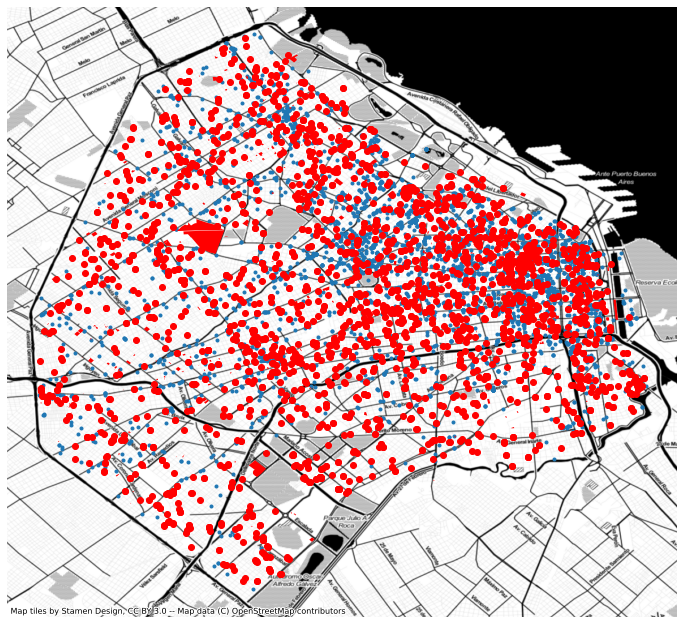

In [33]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_education.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [34]:
pois_education_planar = pois_education.to_crs(epsg=3857)

In [35]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_education_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [36]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'count_educacion'
)
# Evaluar resultados
poi_count.head()

count_educacion
id                 
1                16
3                 3
4                 3
5                 3
6                12

In [37]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"count_educacion": 0})

In [38]:
geo_data_planar.shape

(3670, 33)

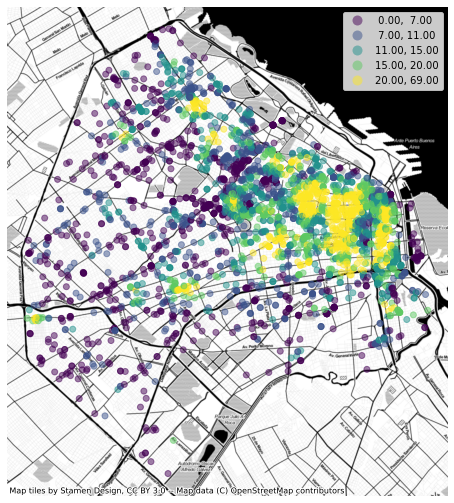

In [39]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="count_educacion",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

#### Avenidas

In [40]:
%%time
pois_roads = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"highway": ['trunk', 'primary', 'secondary']}
).reset_index()#[["osmid", "amenity", "name", "cuisine", "name", "geometry"]]

CPU times: user 1.2 s, sys: 86.7 ms, total: 1.28 s
Wall time: 1.34 s


In [41]:
pois_roads.head()

element_type    osmid    highway  \
0          way  8093354  secondary   
1          way  9937027  secondary   
2          way  9937842  secondary   
3          way  9967926  secondary   
4          way  9971280  secondary   

                                            geometry  bus  \
0  LINESTRING (-58.46323 -34.57510, -58.46268 -34...  NaN   
1  LINESTRING (-58.46497 -34.60275, -58.46552 -34...  NaN   
2  LINESTRING (-58.41052 -34.63507, -58.40934 -34...  NaN   
3  LINESTRING (-58.46205 -34.58513, -58.46100 -34...  NaN   
4  LINESTRING (-58.47084 -34.58747, -58.47022 -34...  NaN   

                                      name source maxspeed  surface  \
0                           Avenida Forest    NaN       60  asphalt   
1  Avenida Teniente General Donato Álvarez    NaN       60  asphalt   
2                           Avenida Brasil    NaN       60  asphalt   
3                      Avenida Triunvirato    NaN       60     sett   
4                        Avenida del Campo    NaN       20  asphalt   

        hazard  ... source:oneway motor_vehicle:conditional  \
0          NaN  ...           NaN                       NaN   
1          NaN  ...           NaN                       NaN   
2          NaN  ...           NaN                       NaN   
3          NaN  ...           NaN                       NaN   
4  school_zone  ...           NaN                       NaN   

  lanes:psv:conditional access:lanes parking:lane:both lanes:bus loc_name  \
0                   NaN          NaN               NaN       NaN      NaN   
1                   NaN          NaN               NaN       NaN      NaN   
2                   NaN          NaN               NaN       NaN      NaN   
3                   NaN          NaN               NaN       NaN      NaN   
4                   NaN          NaN               NaN       NaN      NaN   

  emergency bus_bay destination  
0       NaN     NaN         NaN  
1       NaN     NaN         NaN  
2       NaN     NaN         NaN  
3       NaN     NaN         NaN  
4       NaN     NaN         NaN  

[5 rows x 98 columns]

In [42]:
pois_roads.groupby('highway').highway.count()

highway
primary       860
secondary    3381
trunk          52
Name: highway, dtype: int64

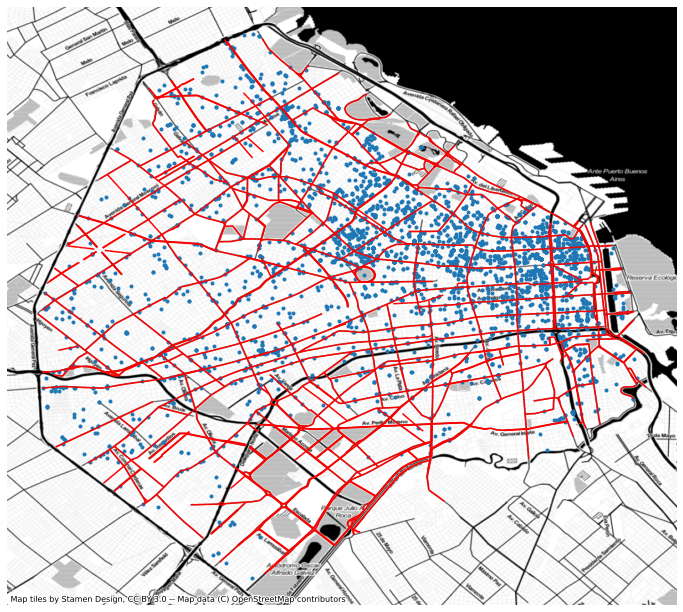

In [43]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_roads.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [44]:
pois_roads_planar = pois_roads.to_crs(epsg=3857)

In [45]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_roads_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [46]:
# Group POIs by Airbnb ID (`id`)
poi_count = joined.groupby(
    "id"
# Keep only POI id column (`osmid`)
)[
    "osmid"
# Count POIs by Airbnb + convert Series into DataFrame
].count().to_frame(
    'count_roads'
)
# Print top of the table
poi_count.head()

count_roads
id             
1             7
2            10
3             9
4            10
5            10

In [47]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"count_roads": 0})

In [48]:
geo_data_planar.shape

(3670, 34)

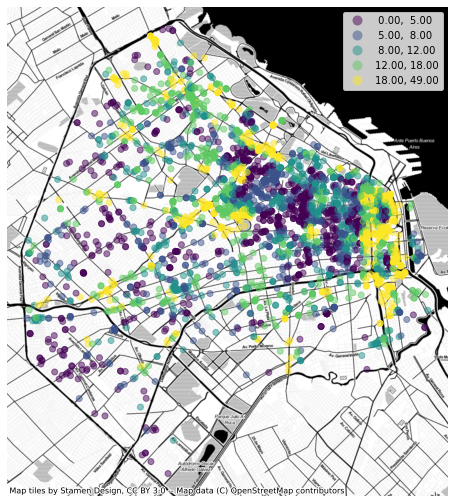

In [49]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="count_roads",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

#### Salud

In [50]:
%%time
pois_salud = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['baby_hatch', 'clinic', 'dentist', 'doctors', 'hospital', 'nursing_home', '	pharmacy', 'social_facility', '	veterinary']}
).reset_index()[["osmid", "amenity", "name", "geometry"]]

CPU times: user 196 ms, sys: 9.21 ms, total: 205 ms
Wall time: 210 ms


In [51]:
pois_salud.groupby('amenity').amenity.count()

amenity
clinic             223
dentist             97
doctors             62
hospital           113
nursing_home         1
social_facility    114
Name: amenity, dtype: int64

In [52]:
pois_salud[:1]

osmid   amenity                     name                     geometry
0  680002885  hospital  Clinica Suizo Argentina  POINT (-58.40187 -34.59387)

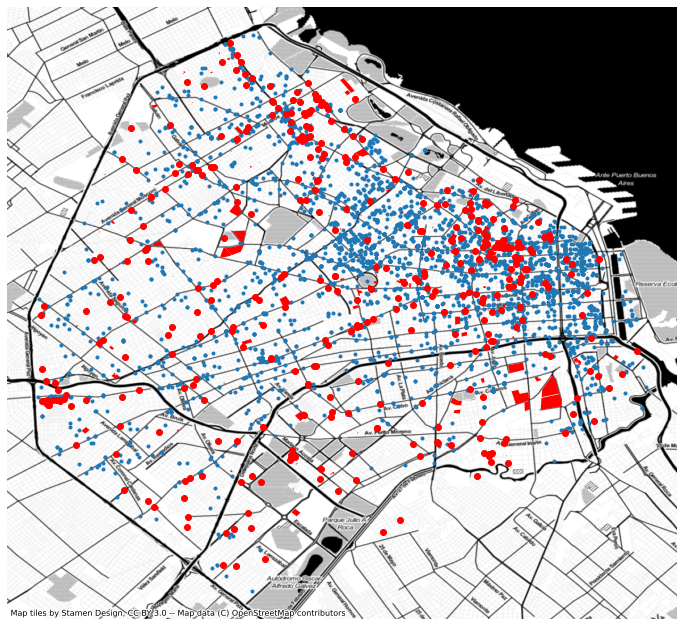

In [53]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_salud.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [54]:
pois_salud_planar = pois_salud.to_crs(epsg=3857)

In [55]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_salud_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [56]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'count_salud'
)
# Evaluar resultados
poi_count.head()

count_salud
id             
1             6
2             1
3             2
4             2
5             2

In [57]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"count_salud": 0})

In [58]:
geo_data_planar.shape

(3670, 35)

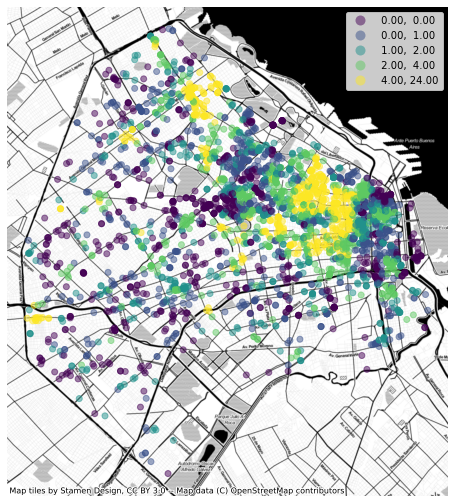

In [59]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="count_salud",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

#### Transporte

In [60]:
%%time
pois_transporte = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"public_transport": ['station', 'stop_area']}
).reset_index()[["osmid", "public_transport", "name", "geometry"]]

CPU times: user 597 ms, sys: 33.5 ms, total: 631 ms
Wall time: 646 ms


In [61]:
pois_transporte.groupby('public_transport').public_transport.count()

public_transport
station    149
Name: public_transport, dtype: int64

In [62]:
pois_transporte[:1]

osmid public_transport              name                     geometry
0  256241985          station  Avenida La Plata  POINT (-58.42640 -34.62697)

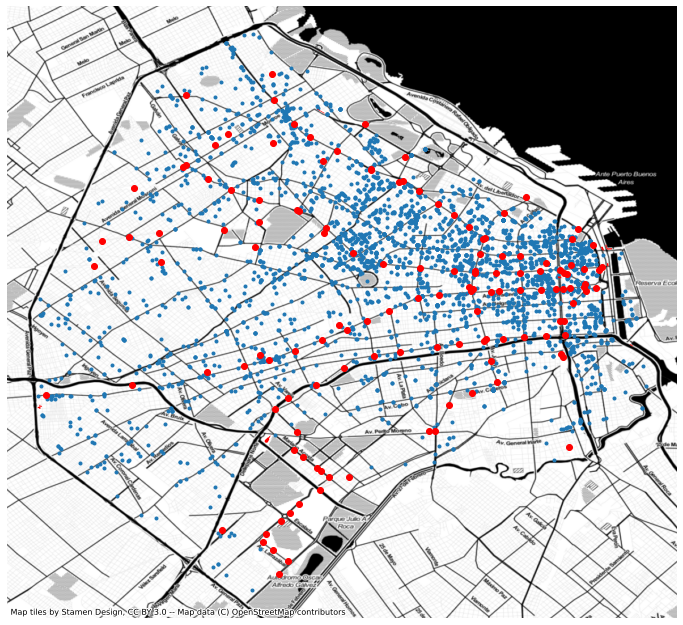

In [63]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_transporte.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [64]:
pois_transporte_planar = pois_transporte.to_crs(epsg=3857)

In [65]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_transporte_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [66]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'count_transporte'
)
# Evaluar resultados
poi_count.head()

count_transporte
id                  
1                  2
6                  1
8                  1
9                  1
10                 1

In [67]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"count_transporte": 0})

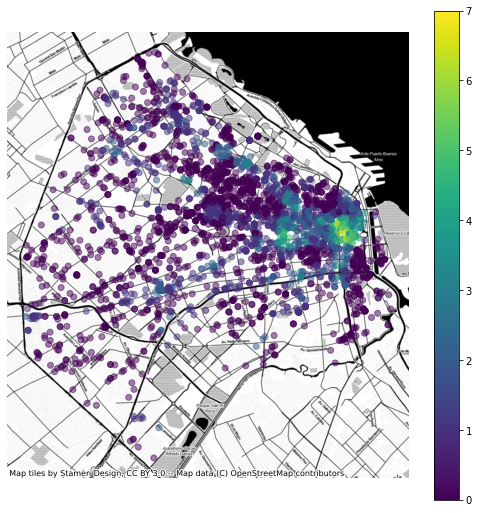

In [68]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="count_transporte",
    #scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

In [69]:
geo_data_planar.shape

(3670, 36)

#### Río

In [70]:
# Descargar geojson de la base de datos del IGN
url = "https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Hidrograf%C3%ADa+y+oceanograf%C3%ADa/Aguas+continentales/areas_de_aguas_continentales_BH140/json"
rios = gpd.read_file(url)#.to_crs(epsg=3857)

In [71]:
rio_de_la_plata = rios[rios.fna == 'Río de la Plata']

<AxesSubplot:>

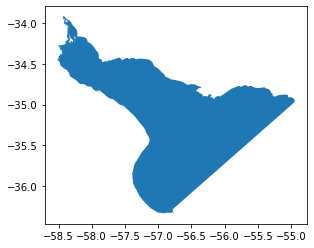

In [72]:
rio_de_la_plata.plot()

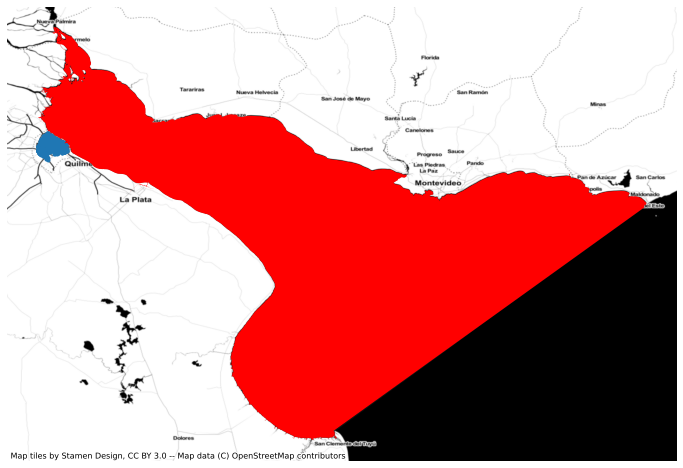

In [73]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
rio_de_la_plata.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [74]:
rio_de_la_plata = rio_de_la_plata.to_crs(epsg=3857)

In [75]:
# Descargar geojson de la base de datos del gobierno de CABA
url = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson"
barrios = gpd.read_file(url).to_crs(epsg=3857)
# Elegir las columnas de interes
barrios = barrios[["BARRIO", "geometry"]]
# Corregir nombres de variables
barrios = barrios.rename(columns = {"BARRIO" : "barrios"})

In [76]:
barrios_costeros = barrios.overlay(rio_de_la_plata, how='intersection')
barrios_costeros['SonCosteros'] = 1
barrios_costeros = barrios_costeros[['barrios', 'SonCosteros']]
# Se elimina la BOCA
barrios_costeros = barrios_costeros[~barrios_costeros.barrios.str.contains("BOCA")]

In [77]:
geo_data_planar = geo_data_planar.merge(
    barrios_costeros, on='barrios', how = 'left'
).fillna({"SonCosteros": 0})

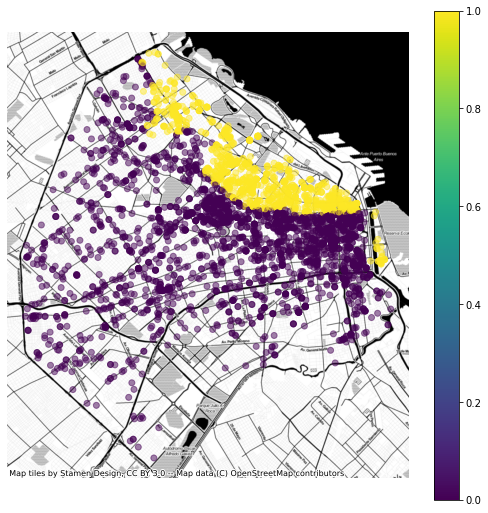

In [78]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="SonCosteros",
    #scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

#### Zonas homogéneas

In [79]:
barrios = barrios.sort_values(by = ['barrios'], axis = 0)

In [80]:
barrios['zonas_EAH'] = ["Centro", "Centro", "Centro", "Sur", "Norte", "Sur", "Centro", "Centro", "Centro",
                        "Centro", "Norte", "Centro", "Centro", "Sur", "Sur", "Sur", "Centro", "Sur",
                        "Sur", "Norte", "Norte", "Sur", "Centro", "Centro", "Sur", "Centro", "Centro",
                        "Norte", "Centro", "Centro", "Centro", "Centro", "Centro", "Sur", "Sur", "Centro",
                        "Centro", "Centro", "Centro", "Sur", "Sur", "Centro", "Centro", "Sur", "Sur", 
                        "Centro", "Sur", "Centro"]

In [81]:
barrios.head()

barrios                                           geometry zonas_EAH
27  AGRONOMIA  MULTIPOLYGON (((-6509642.739 -4108994.113, -65...    Centro
4     ALMAGRO  MULTIPOLYGON (((-6502490.948 -4111563.952, -65...    Centro
24  BALVANERA  MULTIPOLYGON (((-6502385.058 -4109384.676, -65...    Centro
29   BARRACAS  MULTIPOLYGON (((-6497756.011 -4114108.448, -64...       Sur
43   BELGRANO  MULTIPOLYGON (((-6506687.345 -4100950.176, -65...     Norte

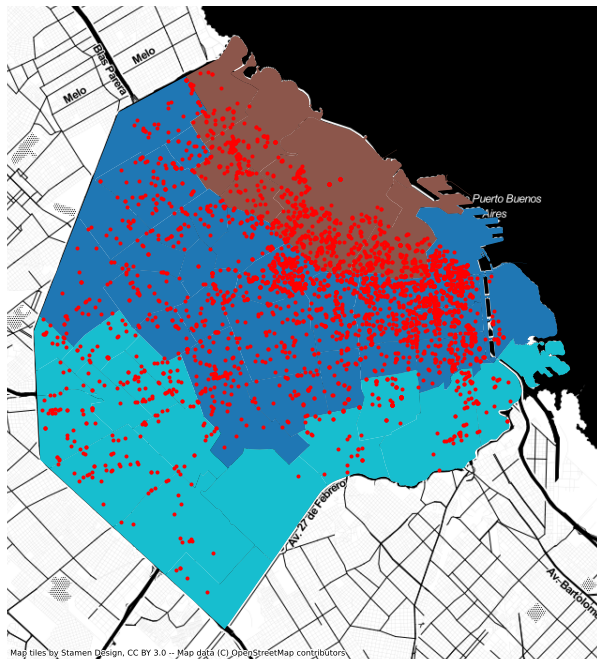

In [82]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot neighbourhoods
barrios.plot(ax=ax, column='zonas_EAH')
# Plot POIs in red
geo_data_planar.plot(ax=ax, marker='.', color = 'r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [83]:
geo_data_planar = geo_data_planar.merge(barrios[['barrios', 'zonas_EAH']])

### Map Synthesis

In [84]:
from libpysal import weights

Al igual que el map matching de la sección anterior, las características espaciales de los datos se pueden resumir o sintetizar para crear mejores modelos. Una alternativa consiste en construit medidas de resumen espaciales. Esto se realiza de la misma manera que en map matching solo que se utilizan los datos propios. Es decir, no se utilizan fuentes externas de información. Por lo tanto, en esta etapa solo estamos interesado en la interacción entre los distintos locales entre sí. Por ejemplo, cuántos locales en venta con similares características compiten entre sí por el mismo comprador. Para cnocer esto nos interesaría saber la distancia con aquellos locales  en venta con similares características como superficie, cantidad de ambientes, etc., dado que locales próximos similares compiten por el mismo comprador pootencial.

#### Cantidad de vecinos

Una primera métrica interesante para caracterizar cada observación es si está rodeada de "vecinos" y en cuyo csao, por cuántos. En esta tarea las matrices de pesos espaciales vuelven a ser muy útiles. A partir de la matriz, si se define que una observación tiene mucho vecinos cuando está rodeada por otras observaciones, entonces esto se traduce en la cardinalidad de la matriz de pesos espaciales. 

Por ejemplo, se puede construir una feature que contenga la cantidad de locales vación que rodean a cada observacion en un rango de 500 metros. 

In [85]:
# Build distance band spatial weights matrix
d500_w = weights.DistanceBand.from_dataframe(
    geo_data_planar, threshold=500, silence_warnings=True
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


In [86]:
card = pd.Series(d500_w.cardinalities)

La feature `card` muestra las zonas con mayor concentración comercial, valores más altos de esta variable indican una mayor cantidad de vecinos. 

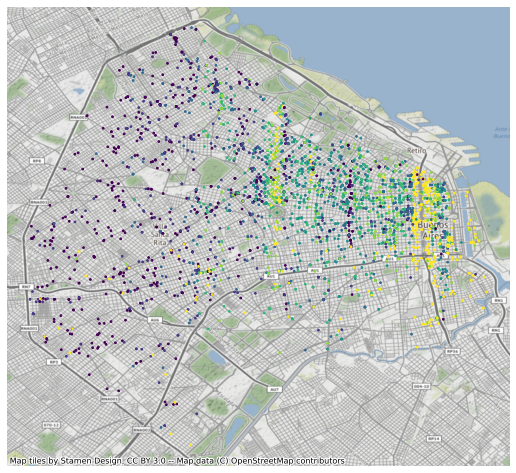

In [87]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Append cardinalities to main Airbnb geo-table
geo_data.assign(
    card=card
# Plot cardinality quantile choropleth
).plot('card', scheme='quantiles', k=7, markersize=3, ax=ax)
# Add basemap
contextily.add_basemap(ax, crs=geo_data.crs)
# Remove axes
ax.set_axis_off();

In [88]:
geo_data_planar['cardinality'] = card

#### Distancia dentro de una zona buffer

Si estamos interesados en conocer la cantidad media de ambientes de los locales alrededor de cada observación es posible una versión estandarizada por file de la banda creada anteriormente. La banda considera a los vecinos que rodean a cada local dentro del umbral de 500 y se calcula el lag de la cantidad de, por ejemplo, ambientes en dicha banda.

In [89]:
geo_data_planar['ambientes'] = geo_data[['ambientes']]

In [90]:
# Row standardise
d500_w.transform = 'r'
# Compute spatial lag of surface of each shop
local_average_surface = weights.lag_spatial(
    d500_w, geo_data_planar[['ambientes']].values
)

Tanto la cantidad de ambientes como la versión lagged están relacionadas pero aportan distintos tipo de finromación y ambas pueden participar del modelo. 

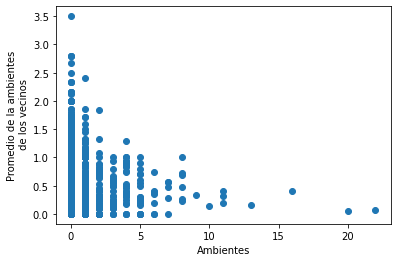

In [91]:
plt.scatter(geo_data_planar[['ambientes']].values, local_average_surface)
plt.xlabel("Ambientes")
plt.ylabel("Promedio de la ambientes\n de los vecinos");

Otra alternativa sería conocer la cantidad más común de ambientes entres los locales, una especie de moda espacial, en lugar de la media. Para esto se podría utilizar la funcion `lag_categorical`. Esta función contempla cada valor dentro de la categoría y selecciona el valor más común entre los vecinos. 

In [92]:
local_mode = weights.lag_categorical(
    d500_w, geo_data_planar[['ambientes']].values
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/spatial_lag.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_labels = np.zeros(y.shape, dtype=np.int)
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(

Dado que ahora la variable se ha discretizado, se puede utilizar `crosstab` para crear una tabla de contingencia para evaluar la relación entre los ambientes de cada observación con sus vecinos. 

In [93]:
crosstab = pd.crosstab(
    geo_data_planar.ambientes, local_mode.flatten()
)
crosstab.columns.name = "nearby"
crosstab

nearby      0.0  1.0  2.0  3.0  4.0
ambientes                          
0.0        2993   12    2    0    1
1.0         363    9    0    0    0
2.0          85    0    2    0    0
3.0          53    2    0    1    0
4.0          33    1    0    0    0
5.0          26    1    0    0    0
6.0          10    0    0    0    0
7.0           6    0    0    0    0
8.0           9    0    0    0    0
9.0           3    0    0    0    0
10.0          1    0    0    0    0
11.0          3    0    0    0    0
13.0          3    0    0    0    0
15.0          4    0    0    0    0
16.0          3    0    0    0    0
18.0          1    0    0    0    0
20.0          1    0    0    0    0
22.0          1    0    0    0    0

A partir de la tabla se puede ver como el caso más común, un monoambiente (N = 3005) está rodeado principalmente por otros locales que poseen solo un ambiente. En el otro extremo del espectro, los locales con más ambientes están más aislados y sólo rodeados por grandes superficies. Esto indicaría que los locales de las zonas más densamente "pobladas" tienden a ser de un sólo ambientes mientras que las grandes superficies están más aisladas y seguramente en la perfieria de la ciudad. 

Dado que la media o la moda son una de las medidas de tendencia central más comunmente usadas, las funciones `lag_spatial` y `lag_categorical` son muy interesantes para crear nuevas features. 

In [94]:
# Funcion para crear variables rezagadas espacialmente
def lag_spatial_variables(data, spatial_weights, variable, categorical = False):
    
    if categorical:
        local_average_surface = weights.lag_categorical(spatial_weights, data[[variable]].values)
    else:
        local_average_surface = weights.lag_spatial(spatial_weights, data[[variable]].values)
    
    return local_average_surface

In [95]:
numerical_variables = ['antig', 'm2total', 'm2cub', 'ambientes', 'banios', 
                      'comisaria_dista', 'obelisco_dista', 'nrobos', 'sup_espacio_verde',
                      'count_gastronomia', 'count_educacion', 'count_roads', 'count_salud',
                      'count_transporte', 'cardinality']

categorical_variable = ['ambientes', 'banios']

In [96]:
# Crear variables lag
for i in categorical_variable:
    # Name of the new variable
    variable = "lagged_" + i
    # Add lagged variable to data
    geo_data_planar[variable] = lag_spatial_variables(data = geo_data_planar, 
                                                 spatial_weights = d500_w, 
                                                 variable = i, 
                                                 categorical = True)
    
for i in numerical_variables:
    # Name of the new variable
    variable = "lagged_" + i
    # Add lagged variable to data
    geo_data_planar[variable] = lag_spatial_variables(data = geo_data_planar, 
                                                 spatial_weights = d500_w, 
                                                 variable = i, 
                                                 categorical = False)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/spatial_lag.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_labels = np.zeros(y.shape, dtype=np.int)
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(

### Features zonas anillos buffer

Una segunda alternativa es utilizar multiples bandas buffer de distintas features. Esta técnica requiere de medidas de resumen de las observaciones que se encuentran sólo dentre de un rango dado de distancias. Por ejemplo, como el tamaño de los locales que se encuentran más allá de los 500 m pero dentro de un rango de 1 km. 

Se puede utilizar la matriz de pesos espaciales usada anteriormente. 

##### Banda buffer

In [97]:
# Promedio dentro de los 500 m
average_within_500 = weights.lag_spatial(
    d500_w, geo_data_planar[['m2total']].values
)

In [98]:
# Promedio dentro de los 1000 m
d1k_w = weights.DistanceBand.from_dataframe(
    geo_data_planar, threshold=1000, silence_warnings=True
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


In [99]:
# Diferencia entre ambas zonas para obtener el anillo
d1k_exclusive = weights.set_operations.w_difference(
    d1k_w, d500_w, constrained=False
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
 There are 18 islands with ids: 113, 329, 337, 338, 341, 489, 490, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1854, 1858, 3638.
  warnings.warn(message)


In [100]:
d1k_exclusive.transform = 'r'
average_500m_to_1k = weights.lag_spatial(
    d1k_exclusive, geo_data_planar[['m2total']].values
)

('WARNING: ', 113, ' is an island (no neighbors)')
('WARNING: ', 329, ' is an island (no neighbors)')
('WARNING: ', 337, ' is an island (no neighbors)')
('WARNING: ', 338, ' is an island (no neighbors)')
('WARNING: ', 341, ' is an island (no neighbors)')
('WARNING: ', 489, ' is an island (no neighbors)')
('WARNING: ', 490, ' is an island (no neighbors)')
('WARNING: ', 1747, ' is an island (no neighbors)')
('WARNING: ', 1748, ' is an island (no neighbors)')
('WARNING: ', 1749, ' is an island (no neighbors)')
('WARNING: ', 1750, ' is an island (no neighbors)')
('WARNING: ', 1751, ' is an island (no neighbors)')
('WARNING: ', 1752, ' is an island (no neighbors)')
('WARNING: ', 1753, ' is an island (no neighbors)')
('WARNING: ', 1754, ' is an island (no neighbors)')
('WARNING: ', 1854, ' is an island (no neighbors)')
('WARNING: ', 1858, ' is an island (no neighbors)')
('WARNING: ', 3638, ' is an island (no neighbors)')


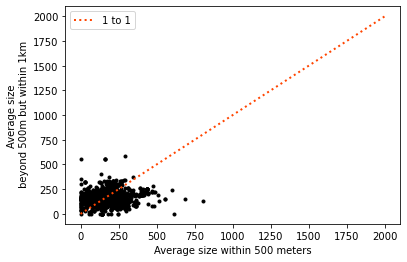

In [101]:
# Plot scatter
plt.scatter(
    average_within_500,
    average_500m_to_1k,
    color='k', marker='.'
)
# Rename horizontal axis
plt.xlabel("Average size within 500 meters")
# Rename vertical axis
plt.ylabel("Average size\n beyond 500m but within 1km")
# Plot line of 45 degrees
plt.plot(
    [0,2000],
    [0,2000], 
    color='orangered', 
    linestyle=':', 
    linewidth=2, 
    label='1 to 1'
)
# Add legend
plt.legend();

In [102]:
geo_data_planar['m2total_buffer_500'] = average_within_500
geo_data_planar['m2total_buffer_500_1000'] = average_500m_to_1k

### Clustering

In [103]:
from hdbscan import HDBSCAN

In [104]:
coordinates = numpy.column_stack(
    (geo_data_planar.geometry.x, geo_data_planar.geometry.y)
)

In [105]:
labels = HDBSCAN(min_cluster_size = 20).fit(coordinates).labels_

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

In [106]:
hulls = geo_data_planar[['geometry']].dissolve(by=labels).convex_hull

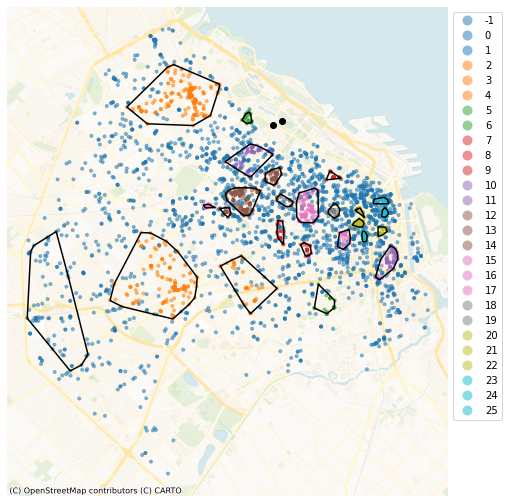

In [107]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot individual Airbnb locations
geo_data_planar.plot(
    # Colour by cluster label
    column=labels,
    # Consider label as categorical
    categorical=True,
    # Add 50% of transparency
    alpha=0.5,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax, 
    # Use circle as marker
    marker='.',
    # Position legend outside the map
    legend_kwds={'bbox_to_anchor': (1,1)}
)
# Plot convex hull polygons for each cluster label
# except that for -1 (observations classified as noise)
hulls[hulls.index != -1].boundary.plot(color='k', ax=ax)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.CartoDB.VoyagerNoLabels
)
# Remove axes
ax.set_axis_off();

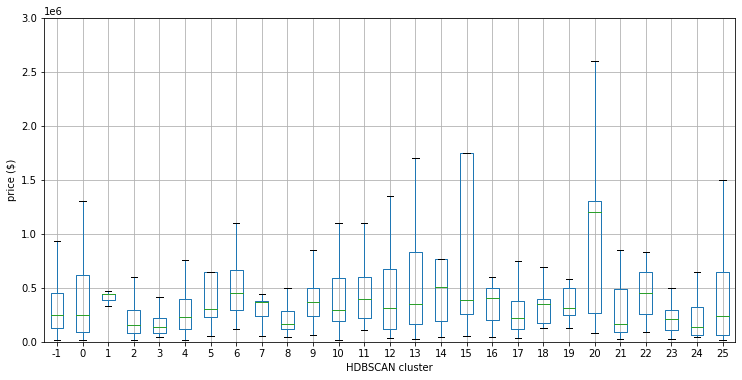

In [108]:
# Set up figure
f = plt.figure(figsize=(12,6))
# Add box plots of price by HDBSCAN cluster
ax = geo_data_planar.boxplot(
    # Plot distribution of 'price'
    "precioUSD", 
    # Group by cluster label, generating one box plot/cluster
    by=labels, 
    # Do not display individual outlier observations
    flierprops=dict(marker=None), 
    # Draw visualisation on the current axis (inside `f`)
    ax=plt.gca()
)
# Set label for horizontal axis
ax.set_xlabel("HDBSCAN cluster")
# Set labels for vertical axis
ax.set_ylabel("price ($)")

# Remove default figure title
plt.gcf().suptitle(None)
# Remove default axis title
ax.set_title(None)
# Re-adjust vertical value range for easier legibility
ax.set_ylim(0,3000000);

In [109]:
geo_data_planar['clusters'] = labels

In [110]:
geo_data_planar.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200        0.0       0 -34.639300 -58.528647   
1   6      0       20     20        0.0       0 -34.636384 -58.527744   
2   8     97      268    268        0.0       0 -34.644692 -58.527501   
3   9      1      270    270        0.0       4 -34.644636 -58.527448   
4  10     40      268    246        0.0       2 -34.644800 -58.527318   

   precioUSD  m2precioUSD  ...  lagged_sup_espacio_verde  \
0    1500000  7500.000000  ...              74085.514625   
1      43000  2150.000000  ...              83858.444500   
2     390000  1455.223881  ...              61292.294000   
3     390000  1444.000000  ...              61477.536000   
4     360000  1463.000000  ...              61046.308000   

   lagged_count_gastronomia  lagged_count_educacion  lagged_count_roads  \
0                     55.75                  20.875               11.75   
1                     33.50                  14.500               13.00   
2                     20.50                   0.500                0.00   
3                     20.00                   0.500                0.00   
4                     20.50                   1.000                0.00   

   lagged_count_salud lagged_count_transporte  lagged_cardinality  \
0              10.875                   1.125               9.375   
1               6.750                   0.750               6.500   
2               2.000                   1.000               2.000   
3               2.000                   1.000               2.000   
4               2.000                   1.000               2.000   

   m2total_buffer_500 m2total_buffer_500_1000 clusters  
0              126.75              321.222222        0  
1              313.50              260.666667        0  
2              269.00              224.357143       -1  
3              268.00              224.357143       -1  
4              269.00              224.357143       -1  

[5 rows x 57 columns]

In [112]:
geo_data_planar.columns

Index(['id', 'antig', 'm2total', 'm2cub', 'ambientes', 'banios', 'latitud',
       'longitud', 'precioUSD', 'm2precioUSD', 'comisaria_dista',
       'obelisco_dista', 'nrobos', 'sup_espacio_verde', 'count_culturales',
       'geometry', 'lon_planar', 'lat_planar', 'calle', 'altura', 'comunas',
       'barrios', 'densidad_poblacional', 'densidad_viviendas', 'distritos',
       'SobreAvenida', 'Aestrenar', 'monoambiente', 'clas_ambientes',
       'clas_banios', 'buffer_500m', 'count_gastronomia', 'count_educacion',
       'count_roads', 'count_salud', 'count_transporte', 'SonCosteros',
       'zonas_EAH', 'cardinality', 'lagged_ambientes', 'lagged_banios',
       'lagged_antig', 'lagged_m2total', 'lagged_m2cub',
       'lagged_comisaria_dista', 'lagged_obelisco_dista', 'lagged_nrobos',
       'lagged_sup_espacio_verde', 'lagged_count_gastronomia',
       'lagged_count_educacion', 'lagged_count_roads', 'lagged_count_salud',
       'lagged_count_transporte', 'lagged_cardinality', 'm2total_

In [113]:
geo_data_planar = geo_data_planar[['id', 'antig', 'm2total', 'm2cub', 'ambientes', 'banios', 
       'precioUSD', 'm2precioUSD', 'comisaria_dista', 'obelisco_dista', 'nrobos', 
        'sup_espacio_verde', 'count_culturales', 'lon_planar', 'lat_planar', 'comunas',
       'barrios', 'densidad_poblacional', 'densidad_viviendas', 'distritos',
       'SobreAvenida', 'Aestrenar', 'monoambiente', 'count_gastronomia', 'count_educacion',
       'count_roads', 'count_salud', 'count_transporte', 'SonCosteros',
       'zonas_EAH', 'cardinality', 'clusters', 'lagged_ambientes', 'lagged_banios',
       'lagged_antig', 'lagged_m2total', 'lagged_m2cub',
       'lagged_comisaria_dista', 'lagged_obelisco_dista', 'lagged_nrobos',
       'lagged_sup_espacio_verde', 'lagged_count_gastronomia',
       'lagged_count_educacion', 'lagged_count_roads', 'lagged_count_salud',
       'lagged_count_transporte', 'geometry'
                    ]]

In [114]:
geo_data_planar.loc[:,"comunas"] = geo_data_planar.comunas.astype(str)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [115]:
geo_data_planar.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3670 entries, 0 to 3669
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        3670 non-null   int64   
 1   antig                     3670 non-null   int64   
 2   m2total                   3670 non-null   int64   
 3   m2cub                     3670 non-null   int64   
 4   ambientes                 3629 non-null   float64 
 5   banios                    3670 non-null   int64   
 6   precioUSD                 3670 non-null   int64   
 7   m2precioUSD               3670 non-null   float64 
 8   comisaria_dista           3670 non-null   float64 
 9   obelisco_dista            3670 non-null   float64 
 10  nrobos                    3670 non-null   int64   
 11  sup_espacio_verde         3670 non-null   float64 
 12  count_culturales          3670 non-null   int64   
 13  lon_planar                3670 non-null 

In [116]:
geo_data_planar.to_csv("./data/modelling_data.csv")

In [349]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/relevamiento-usos-del-suelo/relevamiento-usos-del-suelo-2017.csv' 
uso_suelo = pd.read_csv(url)

In [350]:
uso_suelo.head()

X          Y            SMP           CALLE   NUM TIPO1_16  \
0 -58.455634 -34.596891  047-040A-001C      MONTENEGRO   124        E   
1 -58.455699 -34.596945   047-040A-002  NUEVA ZELANDIA  4820       EP   
2 -58.455750 -34.597013   047-040A-003  NUEVA ZELANDIA  4830        E   
3 -58.455810 -34.597074   047-040A-004  NUEVA ZELANDIA  4840      GAP   
4 -58.455879 -34.597129   047-040A-005  NUEVA ZELANDIA  4850      GAP   

         TIPO2_16  PISOS_16       NOMBRE OBSERVACIO     BARRIO  COMUNA  5_DIG  \
0        VIVIENDA         1          NaN        NaN  CHACARITA    15.0      3   
1      METALURGIA         1  RODOCA S.A.        NaN  CHACARITA    15.0  28900   
2            CASA         1          NaN    E X GAP  CHACARITA    15.0      4   
3  GARAGE PRIVADO         1          NaN        NaN  CHACARITA    15.0  63312   
4  GARAGE PRIVADO         1          NaN        NaN  CHACARITA    15.0  63312   

   4_DIG  3_DIG  2_DIG                                               RAMA  \
0      0      0      0                                          EDIFICIOS   
1   2890    289     28  FABRICACIÓN DE PRODUCTOS ELABORADOS DE METAL, ...   
2      0      0      0                                          EDIFICIOS   
3   6331    633     63            SERVICIOS COMPLEMENTARIOS AL TRANSPORTE   
4   6331    633     63            SERVICIOS COMPLEMENTARIOS AL TRANSPORTE   

                                             SUBRAMA  \
0                                           VIVIENDA   
1   FABRICACIÓN DE PRODUCTOS ELABORADOS DE METAL NCP   
2                                               CASA   
3  SERVICIOS COMPLEMENTARIOS AL TRANSPORTE TERRESTRE   
4  SERVICIOS COMPLEMENTARIOS AL TRANSPORTE TERRESTRE   

                                 SSRAMA  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3  ESTACIONAMIENTOS, COCHERAS Y GARAJES  
4  ESTACIONAMIENTOS, COCHERAS Y GARAJES

In [353]:
# Dado que una misma parcela puede tener más de un uso de suelo se filtran
# aquellos que corresponden al uso comercial
# "SU" ~ "Comercio"
# "L" ~ "Comercio"
# "LG" ~ "Comercio"
# "GAP" ~ "Garage Privado"
uso_suelo = uso_suelo[uso_suelo['TIPO1_16'].isin(["SU", "L", "LG"])]
# Se extraen solo los

In [356]:
uso_suelo = uso_suelo[uso_suelo.PISOS_16 == 1]

In [357]:
uso_suelo = uso_suelo[["SMP", "TIPO1_16", "RAMA"]]
uso_suelo = uso_suelo.rename(columns = {"SMP" : "smp", "TIPO1_16" : "tipo", "RAMA" : "rama"})


In [358]:
uso_suelo.head()

smp tipo                                   rama
10  047-040A-008B    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES
12  047-040A-008E    L                          LOCAL CERRADO
13  047-040A-008E    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES
17   047-040A-012    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES
20   047-040A-015    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES

In [268]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/codigo-urbanistico/codigo-urbanistico.geojson'
codigo_urbano = gpd.read_file(url).to_crs(epsg=3857)

In [269]:
codigo_urbano.head()

gid manzana parcela seccion           smp  uni_edif_1  uni_edif_2  \
0  374398     045     008     024   024-045-008        11.6         0.0   
1  374399     074    033d     024  024-074-033d        31.2         0.0   
2  374400     045     007     024   024-045-007        11.6         0.0   
3  374401     074    033c     024  024-074-033c        31.2         0.0   
4  374402     045     006     024   024-045-006        11.6         0.0   

   uni_edif_3  uni_edif_4  uso_1  ...  fot_em_1  fot_em_2 fot_pl_1 fot_pl_2  \
0         0.0         0.0    2.0  ...       1.6       0.0      1.6      0.0   
1         0.0         0.0    4.0  ...       0.0       0.0      0.0      0.0   
2         0.0         0.0    2.0  ...       1.6       0.0      1.6      0.0   
3         0.0         0.0    4.0  ...       0.0       0.0      0.0      0.0   
4         0.0         0.0    2.0  ...       1.6       0.0      1.6      0.0   

  fot_sl_1 fot_sl_2 cpu_base ae_fot_bas cpu_obs  \
0      1.6      0.0     None        0.0    None   
1      0.0      0.0     None        0.0    None   
2      1.6      0.0     None        0.0    None   
3      0.0      0.0     None        0.0    None   
4      1.6      0.0     None        0.0    None   

                                            geometry  
0  MULTIPOLYGON (((-6501322.989 -4113850.178, -65...  
1  MULTIPOLYGON (((-6500617.674 -4114578.027, -65...  
2  MULTIPOLYGON (((-6501314.777 -4113859.711, -65...  
3  MULTIPOLYGON (((-6500602.633 -4114574.786, -65...  
4  MULTIPOLYGON (((-6501301.539 -4113869.263, -65...  

[5 rows x 49 columns]

In [288]:
codigo_urbano.uso_1.unique()

array([2., 4., 3., 1., 0.])

In [293]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/parcelas/parcelas.geojson'
parcelas = gpd.read_file(url).to_crs(epsg=3857)

In [294]:
parcelas.head()

gid fid_1 featid1 manzana                      obs parcela seccion  \
0  15085047  None    None     098  INFORMACION CONSISTENTE    029a     067   
1  15085048  None    None    031A  INFORMACION CONSISTENTE     017     067   
2  15085049  None    None    018A  INFORMACION CONSISTENTE     018     067   
3  15085050  None    None    031A  INFORMACION CONSISTENTE     018     067   
4  15085051  None    None    018A  INFORMACION CONSISTENTE     019     067   

            smp partida sup_edif unidades fid_2            barrios  comuna  \
0  067-098-029a  237031      385        0  None  VILLA GRAL. MITRE      11   
1  067-031A-017  250532     1536       25  None   VILLA SANTA RITA      11   
2  067-018A-018  251115      183        2  None   VILLA SANTA RITA      11   
3  067-031A-018  250550      281        4  None   VILLA SANTA RITA      11   
4  067-018A-019  251114      140        2  None   VILLA SANTA RITA      11   

    area perimeter acres dist_m2 hectares  \
0  209.7      None  None    None     None   
1  173.4      None  None    None     None   
2  103.8      None  None    None     None   
3  302.9      None  None    None     None   
4  155.8      None  None    None     None   

                                            geometry  
0  MULTIPOLYGON (((-6508745.449 -4111535.266, -65...  
1  MULTIPOLYGON (((-6509742.680 -4111803.483, -65...  
2  MULTIPOLYGON (((-6509895.330 -4112095.507, -65...  
3  MULTIPOLYGON (((-6509811.801 -4111735.339, -65...  
4  MULTIPOLYGON (((-6509890.551 -4112079.911, -65...

In [296]:
parcelas = parcelas[["smp", "geometry"]]
parcelas = parcelas.rename(columns = {"SMP" : "smp"})


In [299]:
#parcelas['geometry'] = parcelas['geometry'].apply(wkt.loads)
#parcelas = gpd.GeoDataFrame(parcelas, crs='epsg:2315', geometry = parcelas.geometry).to_crs(epsg=4326) # Proyectado con Campo Inchauspe 
parcelas = parcelas.to_crs(epsg=4326)

In [300]:
parcelas.head()

smp                                           geometry
0  067-098-029a  MULTIPOLYGON (((-58.46906 -34.61390, -58.46907...
1  067-031A-017  MULTIPOLYGON (((-58.47801 -34.61589, -58.47798...
2  067-018A-018  MULTIPOLYGON (((-58.47938 -34.61805, -58.47938...
3  067-031A-018  MULTIPOLYGON (((-58.47863 -34.61538, -58.47861...
4  067-018A-019  MULTIPOLYGON (((-58.47934 -34.61793, -58.47930...

In [359]:
uso_parcelas = pd.merge(parcelas, uso_suelo, on = 'smp')

In [360]:
geo_data.sjoin(uso_parcelas, how='left')

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0        1      0      200    200          0       0 -34.639300 -58.528647   
1        2     30       50     50          0       1 -34.611807 -58.528138   
2        3     30      414    414          0       2 -34.616468 -58.528111   
3        4     35      414    414          0       2 -34.616344 -58.527918   
4        5     35      285    285          0       1 -34.616344 -58.527918   
...    ...    ...      ...    ...        ...     ...        ...        ...   
3706  3707      0       92     92          0       1 -34.555678 -58.462734   
3707  3708      0       24     24          0       1 -34.554970 -58.466854   
3708  3709      0       77     77          0       1 -34.553865 -58.450116   
3709  3710      0       71     71          0       0 -34.552512 -58.468436   
3710  3711      0      500    500          0       0 -34.547439 -58.452683   

      precioUSD   m2precioUSD  ...         distritos  SobreAvenida  Aestrenar  \
0       1500000   7500.000000  ...  NO CARACTERIZADO             1          1   
1        125000   2500.000000  ...  NO CARACTERIZADO             1          0   
2        590000   1425.120773  ...  NO CARACTERIZADO             1          0   
3        730000   1763.000000  ...  NO CARACTERIZADO             1          0   
4        550000   1929.000000  ...  NO CARACTERIZADO             1          0   
...         ...           ...  ...               ...           ...        ...   
3706     625000   6793.000000  ...  NO CARACTERIZADO             1          1   
3707      50000   2083.000000  ...  NO CARACTERIZADO             0          1   
3708    1200000  15584.000000  ...  NO CARACTERIZADO             0          1   
3709     100000   1408.000000  ...  NO CARACTERIZADO             0          1   
3710    1200000   2400.000000  ...  NO CARACTERIZADO             1          1   

      monoambiente  clas_ambientes  clas_banios index_right          smp  \
0                1               0            0         NaN          NaN   
1                1               0            1         NaN          NaN   
2                1               0            2         NaN          NaN   
3                1               0            2         NaN          NaN   
4                1               0            1         NaN          NaN   
...            ...             ...          ...         ...          ...   
3706             1               0            1     58700.0  041-156-023   
3707             1               0            1         NaN          NaN   
3708             1               0            1         NaN          NaN   
3709             1               0            0         NaN          NaN   
3710             1               0            0         NaN          NaN   

      tipo      rama  
0      NaN       NaN  
1      NaN       NaN  
2      NaN       NaN  
3      NaN       NaN  
4      NaN       NaN  
...    ...       ...  
3706     L  COMERCIO  
3707   NaN       NaN  
3708   NaN       NaN  
3709   NaN       NaN  
3710   NaN       NaN  

[5457 rows x 35 columns]

In [309]:
geo_data.shape

(3670, 31)